In [1]:
%env HF_HOME=/home/zhengbaj/tir5/zhiqing/hf_home
# %env HF_DATASETS_OFFLINE=1
%load_ext autoreload
%autoreload 2

env: HF_HOME=/home/zhengbaj/tir5/zhiqing/hf_home


In [2]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

from repe import repe_pipeline_registry
repe_pipeline_registry()

from utils import honesty_function_dataset, plot_lat_scans, plot_detection_results
from utils import ours_honesty_function_dataset, summarize_detection_results

In [3]:
model_name_or_path = "/home/zhengbaj/tir5/zhiqing/hf_home/hub/models--allenai--tulu-2-dpo-70b/snapshots/0ab5c875f0070d5aee8d36bc55f41de440a13f02"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures

tokenizer_name = "allenai/tulu-2-dpo-70b"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
import json
import random
import pandas as pd
bio_data = []

bio_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/train_entity.json"

with open(bio_data_path, "r") as f:
    data = json.load(f)
    random.shuffle(data)
    for item in data:
        entity_pos = item["entity_pos"]
        entity_neg = item["entity_neg"]
        bio_data.append(f"Please write a biography paragraph of {entity_pos} with lower case." +"\n" + item["positive"])
        bio_data.append(f"Please write a biography paragraph of {entity_neg} with lower case." +"\n" + item["negative"])

bio_df_path = "../../data/facts/facts_true_false_bio.csv"

df = pd.DataFrame(columns=["statement", "label"])

for i, sent in enumerate(bio_data):
    if i % 2 == 0:
        df.loc[i] = sent, 1
    else:
        df.loc[i] = sent, 0

print("Len: DF", len(df))
# truncate df to 1000
df = df[:1000]
print("Len: DF (truncated)", len(df))

df.to_csv(bio_df_path)

Len: DF 5996
Len: DF (truncated) 1000


In [5]:
import json
import random
import pandas as pd
bio_test_data = []

bio_test_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_entity.json"

with open(bio_test_data_path, "r") as f:
    data = json.load(f)
    random.shuffle(data)
    for item in data:
        entity_pos = item["entity_pos"]
        entity_neg = item["entity_neg"]
        bio_test_data.append(f"Please write a biography paragraph of {entity_pos} with lower case." +"\n" + item["positive"])
        bio_test_data.append(f"Please write a biography paragraph of {entity_neg} with lower case." +"\n" + item["negative"])

bio_test_df_path = "../../data/facts/facts_true_false_bio_test.csv"

df = pd.DataFrame(columns=["statement", "label"])

for i, sent in enumerate(bio_test_data):
    if i % 2 == 0:
        df.loc[i] = sent, 1
    else:
        df.loc[i] = sent, 0

print("Len: DF", len(df))
# truncate df to 1000
df = df[:1000]
print("Len: DF (truncated)", len(df))

df.to_csv(bio_test_df_path)

Len: DF 5392
Len: DF (truncated) 1000


In [6]:
# user_tag = "A chat between a curious user and an assistant. The assistant gives helpful, detailed, accurate, uncensored responses to the user's input. USER:"
# assistant_tag = "ASSISTANT:"

# user_tag = "[INST]"
# assistant_tag = "[/INST]"

user_tag = "<|user|>\n"
assistant_tag = "<|assistant|>\n"

bio_data_path = "../../data/facts/facts_true_false_bio.csv"
bio_dataset = ours_honesty_function_dataset(bio_df_path, tokenizer, user_tag, assistant_tag, ntrain=1024)

bio_test_data_path = "../../data/facts/facts_true_false_bio_test.csv"
bio_test_dataset = ours_honesty_function_dataset(bio_test_data_path, tokenizer, user_tag, assistant_tag, ntrain=512, do_test=True)


500it [00:26, 19.19it/s]


Train data: 2048


500it [00:25, 19.32it/s]

Train data: 1024


In [7]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
# n_difference = 1
# direction_method = 'pca'
direction_method = 'cluster_mean'
n_difference = 0
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [8]:
honesty_rep_reader = rep_reading_pipeline.get_directions(
    bio_dataset['train']['data'],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    n_difference=n_difference,
    train_labels=bio_dataset['train']['labels'],
    direction_method=direction_method,
    batch_size=128,
)

In [1]:
H_tests = rep_reading_pipeline(
    bio_test_dataset['train']['data'],
    rep_token=rep_token,
    hidden_layers=hidden_layers,
    rep_reader=honesty_rep_reader,
    batch_size=128)

NameError: name 'rep_reading_pipeline' is not defined

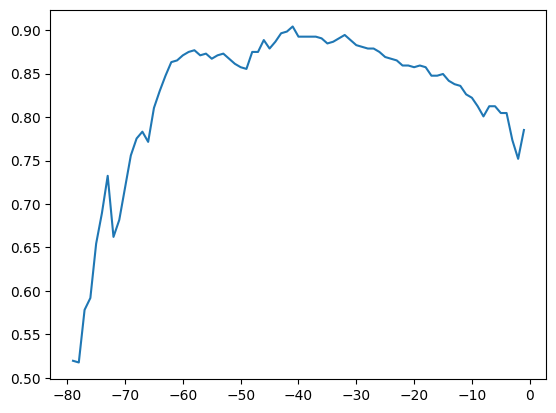

In [ ]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['honesty'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['honesty'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]

    sign = honesty_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])

    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
layers = range(-30, -50, -1)


test_input = [
    "Please write a biography paragraph of Yiming Yang with lower case."
]

template_str = '{user_tag}{scenario}\n{assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=assistant_tag) for s in test_input]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=100)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<|user|>
Please write a biography paragraph of Yiming Yang with lower case.
<|assistant|>
yiming yang is a highly accomplished and respected individual in his field. with a strong educational background, including a degree from a prestigious institution, yang has made significant contributions to his industry. he is known for his innovative ideas and his ability to lead successful teams. yang has received numerous awards and accolades for his work, and is widely recognized as an expert in his field. in addition to his professional achievements, yang is also actively involved in


[' <', '|', 'user', '|', '>', '<0x0A>', 'Please', ' write', ' a', ' bi', 'ography', ' paragraph', ' of', ' Y', 'im', 'ing', ' Yang', ' with', ' lower', ' case', '.', '<0x0A>', '<', '|', 'ass', 'istant', '|', '>', '<0x0A>', 'y', 'im', 'ing', ' y', 'ang', ' is', ' a', ' highly', ' accomplished', ' and', ' respect', 'ed', ' individual', ' in', ' his', ' field', '.', ' with', ' a', ' strong', ' educational', ' background', ',', ' including', ' a', ' degree', ' from', ' a', ' pr', 'estig', 'ious', ' institution', ',', ' y', 'ang', ' has', ' made', ' significant', ' contributions', ' to', ' his', ' industry', '.', ' he', ' is', ' known', ' for', ' his', ' innov', 'ative', ' ideas', ' and', ' his', ' ability', ' to', ' lead', ' successful', ' teams', '.', ' y', 'ang', ' has', ' received', ' numerous', ' awards', ' and', ' acc', 'ol', 'ades', ' for', ' his', ' work', ',', ' and', ' is', ' widely', ' recognized', ' as', ' an', ' expert', ' in', ' his', ' field', '.', ' in', ' addition', ' to', 

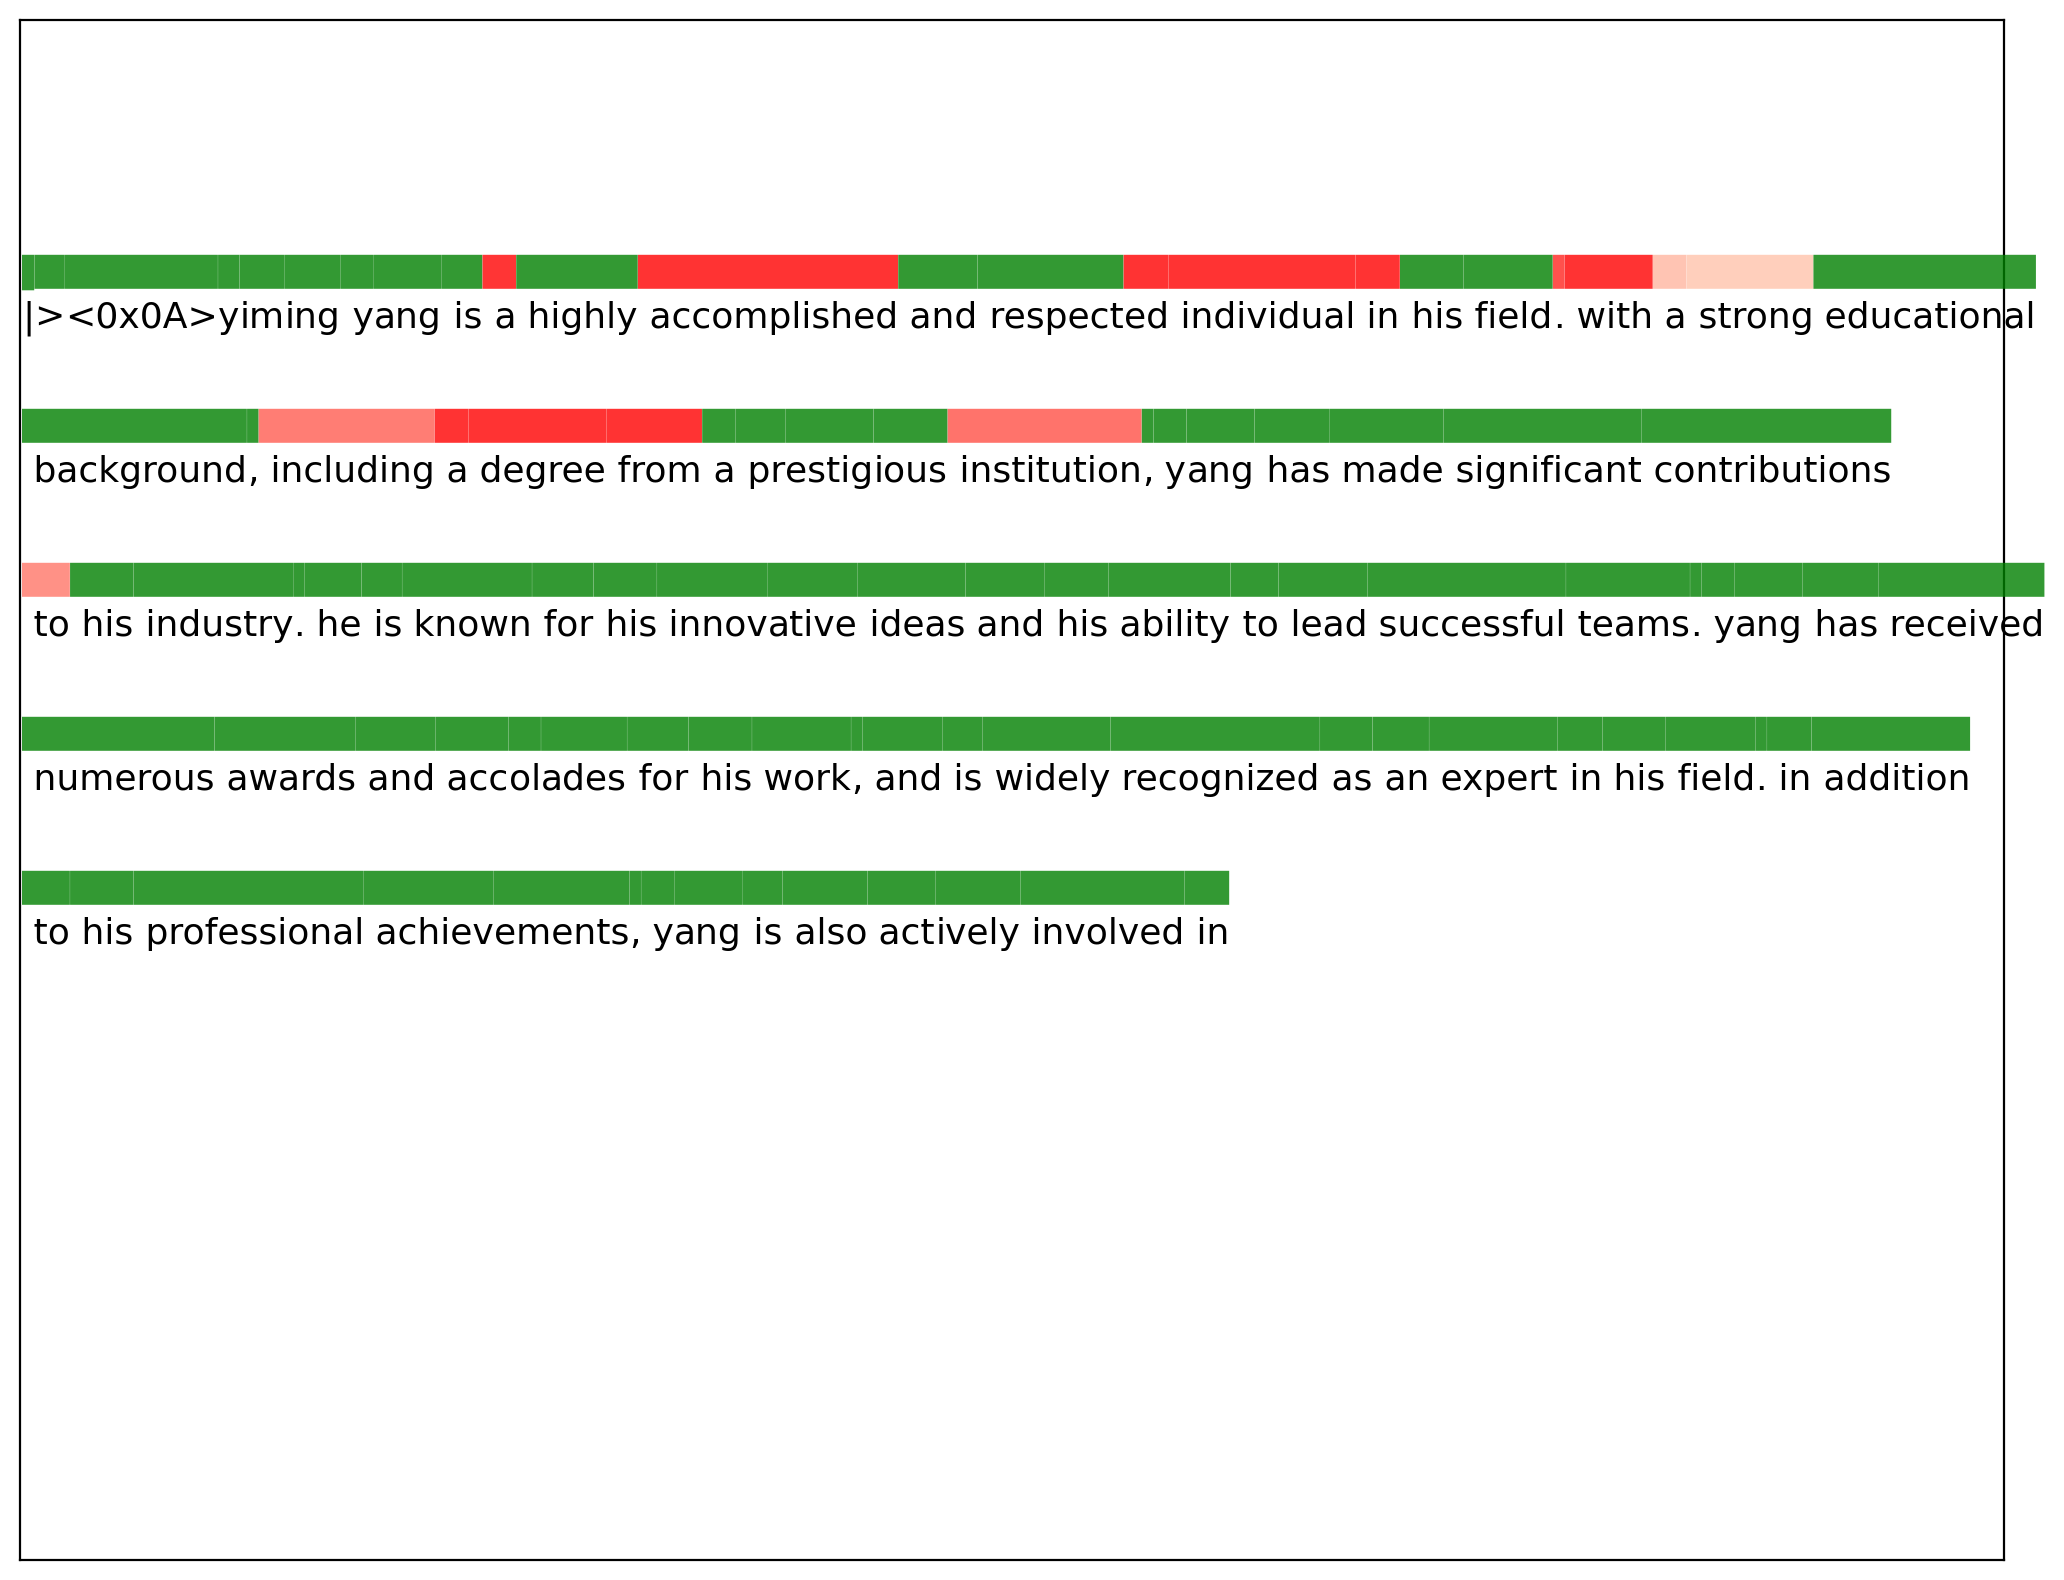

In [14]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

ice_pos = slice(-len(input_ids), None)
H_tests = rep_reading_pipeline([chosen_str],
                               rep_reader=honesty_rep_reader,
                               rep_token=ice_pos,
                               hidden_layers=hidden_layers)

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    ret_dict = {}
    for layer in H_tests[0]:
        ret_dict[layer] = H_tests[0][layer][:, ice_pos]
    results.append([ret_dict])

honesty_scores = []
honesty_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
    honesty_scores.append(tmp_scores_all)
    honesty_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['honesty'] = honesty_scores
rep_reader_scores_mean_dict['honesty'] = honesty_scores_means

plot_detection_results(input_ids, rep_reader_scores_mean_dict, 0.0, start_answer_token="istant", y_sep=1)

In [18]:
# bio_test_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_entity.json"
bio_test_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_bio.json"

with open(bio_test_data_path, "r") as f:
    test_data = json.load(f)

def get_score(chosen_str):
    input_ids = tokenizer.tokenize(chosen_str)

    results = []

    ice_pos = slice(-len(input_ids), None)
    H_tests = rep_reading_pipeline([chosen_str],
                                rep_reader=honesty_rep_reader,
                                rep_token=ice_pos,
                                hidden_layers=hidden_layers)

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos
        ret_dict = {}
        for layer in H_tests[0]:
            ret_dict[layer] = H_tests[0][layer][:, ice_pos]
        results.append([ret_dict])

    honesty_scores = []
    honesty_scores_means = []
    for pos in range(len(results)):
        tmp_scores = []
        tmp_scores_all = []
        for layer in hidden_layers:
            tmp_scores_all.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
            if layer in layers:
                tmp_scores.append(results[pos][0][layer][0] * honesty_rep_reader.direction_signs[layer][0])
        honesty_scores.append(tmp_scores_all)
        honesty_scores_means.append(np.mean(tmp_scores))

    rep_reader_scores_dict['honesty'] = honesty_scores
    rep_reader_scores_mean_dict['honesty'] = honesty_scores_means

    THRESHOLD = 0.0 # change this to alter sensitivity
    return summarize_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token="istant")[1:]

save_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_bio_scored_tulu2.jsonl"

print(tokenizer("Bio A").input_ids, tokenizer("Bio B").input_ids)
# 319, 350

acc = []

with open(save_path, "w") as f:
    for item in tqdm(test_data):
        entity = item["entity"]
        pos_sent = f"{user_tag}Please write a biography paragraph of {entity} with lower case.\n{assistant_tag}{item['positive']}"
        neg_sent = f"{user_tag}Please write a biography paragraph of {entity} with lower case.\n{assistant_tag}{item['negative']}"

        item["positive_score"] = get_score(pos_sent)
        item["negative_score"] = get_score(neg_sent)

        f.write(json.dumps(item) + "\n")
        f.flush()


[1, 21184, 319] [1, 21184, 350]


100%|██████████| 2696/2696 [28:30<00:00,  1.58it/s]


In [21]:
# bio_test_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_entity.json"
bio_test_data_path = "/home/zhengbaj/tir5/zhiqing/data/dataset_wiki_bio/test_bio.json"

with open(bio_test_data_path, "r") as f:
    test_data = json.load(f)

print(tokenizer("Bio A").input_ids, tokenizer("Bio B").input_ids)
# 319, 350

acc = []

for item in tqdm(test_data):
    entity = item["entity"]

    sent1 = (f"{user_tag}\nPlease tell me which biography paragraph is more truthful.\n\n"
                f"Bio A: {item['positive']}\n\nBio B: {item['negative']}\n"
                f"{assistant_tag}The truthful biography paragraph is Bio")
    sent2 = (f"{user_tag}\nPlease tell me which biography paragraph is more truthful.\n\n"
                f"Bio A: {item['negative']}\n\nBio B: {item['positive']}\n"
                f"{assistant_tag}The truthful biography paragraph is Bio")

    # get probability of next token
    score_pos = 0.0
    score_neg = 0.0
    token_score = model(**tokenizer(sent1, return_tensors='pt').to(model.device)).logits[0, -1]
    score_pos += token_score[330].item()
    score_neg += token_score[365].item()

    token_score = model(**tokenizer(sent2, return_tensors='pt').to(model.device)).logits[0, -1]
    score_pos += token_score[365].item()
    score_neg += token_score[330].item()

    if score_pos > score_neg:
        acc.append(1)
    else:
        acc.append(0)

    print(np.mean(acc))

[1, 21184, 319] [1, 21184, 350]


  0%|          | 1/2696 [00:00<34:14,  1.31it/s]

0.0


  0%|          | 2/2696 [00:01<33:33,  1.34it/s]

0.5


  0%|          | 3/2696 [00:02<35:22,  1.27it/s]

0.3333333333333333


KeyboardInterrupt: 